# Maximum Likelihooh Amplitude Estimation (MLAE)

% Present notebook reviews the **Maximum Likelihood Amplitude Estimation** algorithm (**MLAE**).

Present notebook and module are based on the following references:

* *Suzuki, Y., Uno, S., Raymond, R., Tanaka, T., Onodera, T., & Yamamoto, N.*. Amplitude estimation without phase estimation. Quantum Information Processing, 19(2), 2020. https://arxiv.org/abs/1904.10246

* NEASQC deliverable: *D5.1: Review of state-of-the-art for Pricing and Computation of VaR https://www.neasqc.eu/wp-content/uploads/2021/06/NEASQC_D5.1_Review-of-state-of-the-art-for-Pricing-and-Computation-of-VaR_R2.0_Final.pdf*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")

In [2]:
from qat.qpus import get_default_qpu
linalg_qpu = get_default_qpu()

In [3]:
from libraries.data_loading import load_probability
from libraries.data_extracting import get_results
from libraries.utils import bitfield_to_int

## 1. Oracle generation

Before doing any amplitude estimation we want to load some data into the quantum circuit, as this step is only auxiliary to see how the algorithm works, we are just going to load a discrete probability distribution. In this case we will have a circuit with $n=3$ qubits which makes a total of $N = 2^n = 8$ states. The discrete probability distribution that we are going to load is:
$$p_d = \dfrac{(0,1,2,3,4,5,6,7)}{0+1+2+3+4+5+6+7+8}.$$


In [4]:
n = 3
N = 2**n
x = np.arange(N)
probability = x/np.sum(x)

Note that this probability distribution is properly normalised. For loading this probability into the quantum circuit we will use the function *load_probability*. The state that we are going to get is:
    $$|\Psi\rangle = \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{1}|1\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].$$

In [5]:
oracle = load_probability(probability)

For more information about loading data into the quantum circuit see the notebook *data_loading_use*.

## 2. MLAE algorithm step by step.

The problem of amplitude estimation is the following. Given an oracle:

$$\mathcal{0}|0\rangle = |\Psi\rangle = \sqrt{a}|\Psi_0\rangle +\sqrt{1-a}|\Psi_1\rangle,$$

where $|\Psi_0\rangle$ and $|\Psi_1\rangle$ are orthogonal states, we want to estimate $\sqrt{a}$. We can define an associated angle to $\sqrt{a}$ as $\sin^2{\theta} = a$, and the problem is thus rewritten as:
$$\mathcal{O}|0\rangle = |\Psi \rangle = \sin(\theta)|\Psi_0\rangle +\cos(\theta)|\Psi_1\rangle,$$


We have implemented and python class called **MLAE** (in the script **maximum_likelihood_ae.py**) that allows us implement the **MLAE** algorithm. In this section we are going to describe the class step by step and explain the basics of the **MLAE** algorithm.

### Example

In [6]:
#import the class
from libraries.AE.maximum_likelihood_ae import MLAE

For showing how our class and the algorithm works, we will define the following amplitude estimation problem:
$$
    \begin{array}{l}
    &\mathcal{O}\longrightarrow \mathcal{P}.\\
    & |\Psi\rangle \longrightarrow \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{1}|1\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].\\
    & \sin(\theta)|\Psi_0\rangle \longrightarrow \dfrac{\sqrt{1}}{\sqrt{0+1+2+3+4+5+6+7+8}}|1\rangle.\\
    & \cos(\theta)|\Psi_1\rangle \longrightarrow \scriptstyle \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].\\
    \end{array}
$$
The target state, in this case is $|1\rangle$. It's binary representation is $001$. This has to be passed to the target variable as a list. Moreover we have to provide the list of qubits where we are acting, in this case is just $[0,1,2]$, the whole register.

In [7]:
mlae = MLAE(oracle,target = [0,0,1],index = [0,1,2])

### The grover operator

The foundations of any amplitude estimation algorithm is the grover operator $\mathcal{Q}$. We recall that the grover operator has the following effect over our state $|\Psi\rangle$:
$$\mathcal{G}^{m}|\Psi\rangle = |\Psi \rangle = \sin\left((2m_k+1)\theta\right)|\Psi_0\rangle +\cos\left((2m_k+1)\theta\right)|\Psi_1\rangle,$$
for more information about the grover operator and the amplitude amplification algorithm check the notebook about amplitude amplification.

The process of generating the corresponding grover oracle is handled automatically in the class when we instance it. To see the grover operator in action we can call the method *run_step* of the class. The input of the method is:

* m_k: the number of times the Grover-like operator will be applied.
* n_k : number of shots.

The method returns:
* h_k: number of positive outcomes

In [8]:
m_k = 3
n_k = 100
h_k = mlae.run_step(m_k,n_k)

From the number of positive outcomes it is straightforward to estimate the probability of getting the state $|1\rangle$ (the positive outcome):
$$ \sin^2\left((2m_k+1)\hat{\theta}\right) = \dfrac{h_k}{n_k} = \hat{p}(|\Psi_0\rangle)\approx p(|\Psi_0\rangle).$$
Here we use the $\hat{}$ to distinguish between the estimated values from the real ones.
So we have a first estimation of our target amplitude:

In [9]:
angle_estimation = np.arcsin(np.sqrt(h_k/n_k))/(2*m_k+1)
estimation = np.sin(angle_estimation)**2

In [10]:
print("First estimation: ",estimation)
print("Exact probability: ",probability[1])

First estimation:  0.03327241568620759
Exact probability:  0.03571428571428571


The question now is, ¿how can we consistently improve this result?

### The Likelihood

To improve our results we will throw different experiments and combine its information into a single result. To do so we will use the likelihood. First, what is the **likelihood**?

In general, the likelihood $L(a|b)$ is the probability of obtaining $b$ conditioned to $a$, that is $L(a|b) = p(b|a)$.

In our specific case, given the result of an experiment $h_k$ we want to know the probability of an angle $\theta$ being the one that has generated it:
$$p(\theta|h_k).$$
From all the possible values of theta we will propose as a solution the one with most probability.

As computing $p(\theta|h_k)$ is not completely straightforward we will compute instead $p(h_k|\theta)$ which is proportional to the other one by Baye's theorem. The associated likelihood is $L(\theta|h_k) = p(h_k|\theta)$. The value of this likelihood is:

$$L(\theta|h_k) = \sin^2\left((2m_k+1)\theta\right)^{h_k}\cos^2\left((2m_k+1)\theta\right)^{n_k-h_k}.$$

This is because each measurment is independent of the other measurements, the probability of obtaining the state $|1\rangle$ is given by $\sin^2\left((2m_k+1)\theta\right)$  and the probability of the state $|0\rangle$ is given by $\cos^2\left((2m_k+1)\theta\right)$.

To compute the likelihood for a given experiment we can use the function *likelihood*. The input of the method is:

* angle : the angle.
* m_k: the number of times the Grover-like operator will be applied.
* n_k : number of shots.
* h_k: number of positive outcomes

The method returns:
* l_k: likelihood of the angle




In [11]:
theta = np.linspace(0,np.pi/2,1000)
l_k = np.zeros(len(theta))
for i in range(len(theta)):
    l_k[i] = mlae.likelihood(theta[i],m_k,n_k,h_k)

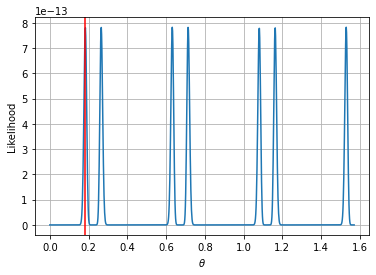

In [12]:
plt.plot(theta,l_k, '-')
plt.axvline(angle_estimation,color = 'r')
plt.xlabel(r'$\theta$')
plt.ylabel('Likelihood')
plt.grid()

In blue is depicted the likelihood function for different values of $\theta$. In red we have the estimation we made in the previous section. As we see there are multiple values that maximize the likelihood function. If we combine the information from different $(m_k,h_k)$ we can get better estimations.

Therefore we define a combined likelihood as:
$$L(\theta,\mathbf{h}) = \prod_{k = 0}^M l_k(\theta,h_k).$$
$$\mathbf{h} = (h_0, h_1,...,h_M)$$

Instead of dealing with the maximimization problem, we define the equivalent mimimization problem which substituting the combined likelihood with the cost function $C$:
$$C(\theta) = -\log\left(L(\theta,\mathbf{h})\right)$$

The idea is the is to find the $\theta^*$ that minimizes the cost function:
$$\theta^* = \arg \min_{\theta} C(\theta)$$ 

This process can simply be done calling the function minimize.

In [13]:
theta = mlae.optimize()

We can compare it with the classical result, recall that:
$$\sin^2(\theta) = a$$

In [14]:
print("Quantum result: ",np.sin(theta)**2)
print("Classical result: ",probability[1])

Quantum result:  [0.04095356]
Classical result:  0.03571428571428571


If you execute the minimize function more times you will see that the results of the quantum estimation change, try it.

## Options of the MLAE class

So far we have dealt with how the algorithm works. Next we discuss a few extra options available.

### The schedule

As we said, we want to combina the information of different experiments. In general each experiment can be characterised by the number of aplications of the grover oracle $m_k$ and the number of shots $n_k$. A list of both is what we call a **schedule**. In the next cell we define a specific schedule and give it to the class:

In [15]:
m_k = [0,1,2,3,4]
n_k = [10]*len(m_k)
schedule = [m_k,n_k]

In [16]:
target = [0,0,1]
index = [0,1,2]
mlae = MLAE(oracle,target = [0,0,1],index = [0,1,2],schedule = schedule)

In [17]:
angle = mlae.optimize()
print("Quantum result: ",np.sin(angle)**2)
print("Classical result: ",probability[bitfield_to_int(target)])

Quantum result:  [0.04202258]
Classical result:  0.03571428571428571


We don't need to define the schedule at initialization, we can define it after by simply assigning attribute schedule to the schedule we want:

In [18]:
m_k = [0,1,2,4,8,16]
n_k = [10]*len(m_k)
schedule = [m_k,n_k]
mlae.schedule = schedule

In [19]:
angle = mlae.optimize()
print("Quantum result: ",np.sin(angle)**2)
print("Classical result: ",probability[bitfield_to_int(target)])

Quantum result:  [0.03472286]
Classical result:  0.03571428571428571


### The optimizer

To find the angle that mimimizes the cost function we need to use a minimization algorithm. The default one is the brute force one, but we can use another one.
The optimizer that we have to pass to the class needs to be a function of just one variable: the angle. This is straightforward using lambda functions. In this case, we will do an example with differential-evolution algorithm from the scipy library.

In [20]:
import scipy.optimize as so

The *differential evolution* algorithm just needs as input the function to be minimized and the bounds where the minimization is done.

In [21]:
bounds = [[0.,np.pi/2]]
differential_evolution = lambda f: so.differential_evolution(f,bounds = bounds)

Now we just need to assign the new optimizer to the attribute *optimizer*

In [22]:
mlae.optimizer = differential_evolution

In [23]:
result = mlae.optimize()
angle = result.x
print("Quantum result: ",np.sin(angle)**2)
print("Classical result: ",probability[bitfield_to_int(target)])

Quantum result:  [0.65476426]
Classical result:  0.03571428571428571


The optimizer can be also given at initialization.

### The qpu 

We can use a different qpu from the default one by just giving it to the attribute *qpu*